In [15]:
import scipy as scp

In [18]:
from scipy import special

In [2]:
import numpy as np

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
from tqdm import tqdm_notebook

In [5]:
import matplotlib.gridspec as gridspec

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

### Extraction des données

##### Binary Alpha Digits

Import du fichier .mat

référence : https://docs.scipy.org/doc/scipy/reference/tutorial/io.html

In [3]:
import scipy.io as sio

In [89]:
classlabels = sio.loadmat('binaryalphadigs.mat')['classlabels'][0]
np.save('BAD_classlabels.npy',classlabels)

In [8]:
dat = sio.loadmat('binaryalphadigs.mat')['dat']
np.save('BinaryAlphaDigs.npy',dat)

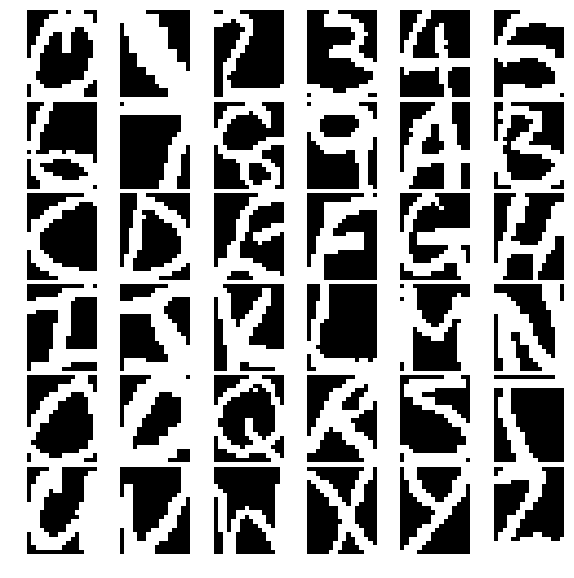

In [49]:
plt.figure(figsize = (10,10))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(len(dat)):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(dat[i,np.random.randint(0,len(dat[i])-1)],cmap=plt.cm.gray)
    
plt.show()

##### MNIST

from : https://stackoverflow.com/a/53181925

In [45]:
import struct

In [70]:
def read_images(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
    np.save(filesave,data)

In [73]:
def read_labels(filename,filesave):
    with open(filename,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f,dtype=np.dtype(np.uint8))
    np.save(filesave,labels)

In [72]:
read_images('../MNIST/t10k-images-idx3-ubyte','MNIST_test_images.npy')
read_images('../MNIST/train-images-idx3-ubyte','MNIST_train_images.npy')

In [75]:
read_labels('../MNIST/t10k-labels-idx1-ubyte','MNIST_test_labels.npy')
read_labels('../MNIST/train-labels-idx1-ubyte','MNIST_train_labels.npy')

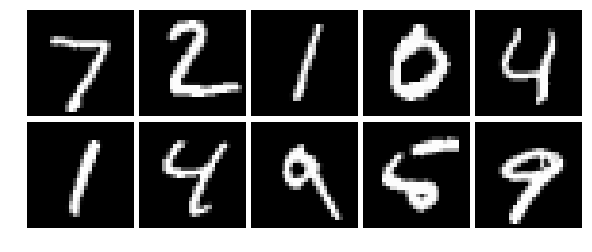

In [58]:
plt.figure(figsize = (10,4))
gs1 = gridspec.GridSpec(2, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(10):
    
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.imshow(data[i,:,:],cmap=plt.cm.gray)
    
plt.show()

### Reading npy files

In [90]:
AD = np.load('BinaryAlphaDigs.npy')
AD_labels = np.load('BAD_classlabels.npy')

In [78]:
MNIST_test_images = np.load("MNIST_test_images.npy")
MNIST_test_labels = np.load("MNIST_test_labels.npy")
MNIST_train_images = np.load("MNIST_train_images.npy")
MNIST_train_labels = np.load("MNIST_train_labels.npy")

# 3.1 Construction d'un RBM et test sur Binary AlphaDigits

In [481]:
def lire_alpha_digit(char_list=None):
    
    AD = np.load('BinaryAlphaDigs.npy')
    AD_labels = np.load('BAD_classlabels.npy')
    
    array_list = []
    
    char_list = char_list or AD_labels
    
#     print(char_list.astype(str))
    
    for c in np.core.defchararray.upper([*char_list]):
        
        idx = np.where(AD_labels==c)[0][0]
        AD_char = np.array([*AD[idx,:]])
        
        n = AD_char.shape[0]
        m = AD_char.shape[1]*AD_char.shape[2]
        
        AD_r = AD_char.reshape([n,m])
        
        array_list.append(AD_r)
        
    return np.concatenate(array_list)

In [515]:
X_6 = lire_alpha_digit(['6'])

In [482]:
X = lire_alpha_digit()

In [706]:
class RBM:
    
    f_act = special.expit
    
    def __init__(self,v_size=320,h_size=10,A=None,B=None,W=None):
        
        self.v_size=v_size
        self.h_size=h_size
        
        self.A = A or np.zeros(v_size)[:,None]
        self.B = B or np.zeros(h_size)[:,None]
        self.W = W or np.random.normal(scale=0.1,size=(h_size,v_size))
        
    def forward(self,x):
        
        if len(x.shape) == 1:
            return self.f_act(self.B + np.dot(self.W,x)[:,None])
        else:
            return self.f_act(np.tile(self.B,(1,x.shape[1])) + np.dot(self.W,x))
    
    def backward(self,y):
        
        if len(y.shape) == 1:
            return self.f_act(self.A + np.dot(self.W.T,y)[:,None])
        else:
            return self.f_act(np.tile(self.A,(1,y.shape[1])) + np.dot(self.W.T,y))
    
    def contrastive_divergence_1(self,x):
        
        proba_h_x = self.forward(x)
        h_0 = np.random.binomial(1,proba_h_x)
        
        proba_v_h = self.backward(h_0)
        v_1 = np.random.binomial(1,proba_v_h)
        
        proba_h_v = self.forward(v_1)
        
        return proba_h_x,proba_v_h,v_1,proba_h_v
    
    def train(self,X,n_epochs=20,l_r=1.0,batch_size=32,lr_decay=0.5,cold_start=True):
        
        if cold_start:
            
            self.A = np.zeros(self.v_size)[:,None]
            self.B = np.zeros(self.h_size)[:,None]
            self.W = np.random.normal(scale=0.1,size=(self.h_size,self.v_size))
        
        self.erreur = []
        n = X.shape[0]
        
        for k in tqdm_notebook(range(n_epochs),desc='Epochs'):
        
            np.random.shuffle(X)

            for i in range(int(np.ceil(n/batch_size))):

                i_next = (i+1)*batch_size
                end = n if i_next > n else i_next
                
                X_batch = X[i*batch_size:end,:].T
                Phx,Pvh,v1,Phv = self.contrastive_divergence_1(X_batch)
                
                dW = np.dot(Phx,X_batch.T) - np.dot(Phv,v1.T)
                dA = np.sum(X_batch,1) - np.sum(v1,1)
#                 dA = np.sum(X_batch - v1,1)
                dB = np.sum(Phx,1) - np.sum(Phv,1)
#                 dB = np.sum(Phx - Phv,1)
                
                self.W += l_r*dW
                self.A += l_r*dA[:,None]
                self.B += l_r*dB[:,None]

#                 if i == np.ceil(n/batch_size)-1:
                self.erreur.append(((X_batch - v1)**2).mean())
#                 self.erreur.append(1/(i_next-i)*np.sum(np.linalg.norm(Pvh-X_batch)))
                
            l_r *= lr_decay
            
    def show_erreur(self):
        
        plt.plot(self.erreur)
        plt.show()
        
    def show_random_init(self):
        
        V = np.random.normal(size=(self.A.shape[0],1))
        out = self.backward(self.forward(V))
        plt.imshow(np.reshape(out,(20,16)),cmap='gray')
        plt.show()
        
    def show_canonical(self,n_cols=5):
        
        n = self.B.shape[0]
        
        plt.figure(figsize=(n_cols*2,n//2))
        gs1 = gridspec.GridSpec(int(np.ceil(n/n_cols)), n_cols)
        gs1.update(wspace=0.025, hspace=0.025)

        for i in range(n):

            ax = plt.subplot(gs1[i])
            ax.axis('off')
            H = np.zeros(shape=self.B.shape)
            H[i] = 1
            out = self.backward(H)
            ax.imshow(np.reshape(out,(20,16)),cmap='gray')
            
        plt.show()
        
    def show_from_canonical_h(self,i):
        
        H = np.zeros(shape=self.B.shape)
        H[i] = 1
        out = self.backward(H)
        plt.imshow(np.reshape(out,(20,16)),cmap='gray')
        plt.show()

In [726]:
R = RBM(h_size=36)

In [737]:
R.train(X,batch_size=10,n_epochs=20,l_r=0.1,lr_decay=0.5)

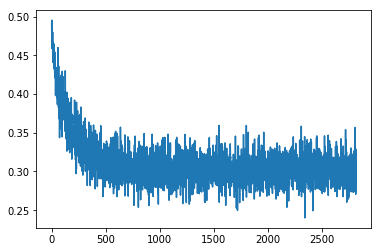

In [738]:
R.show_erreur()

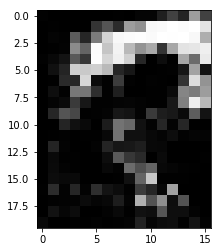

In [739]:
R.show_random_init()

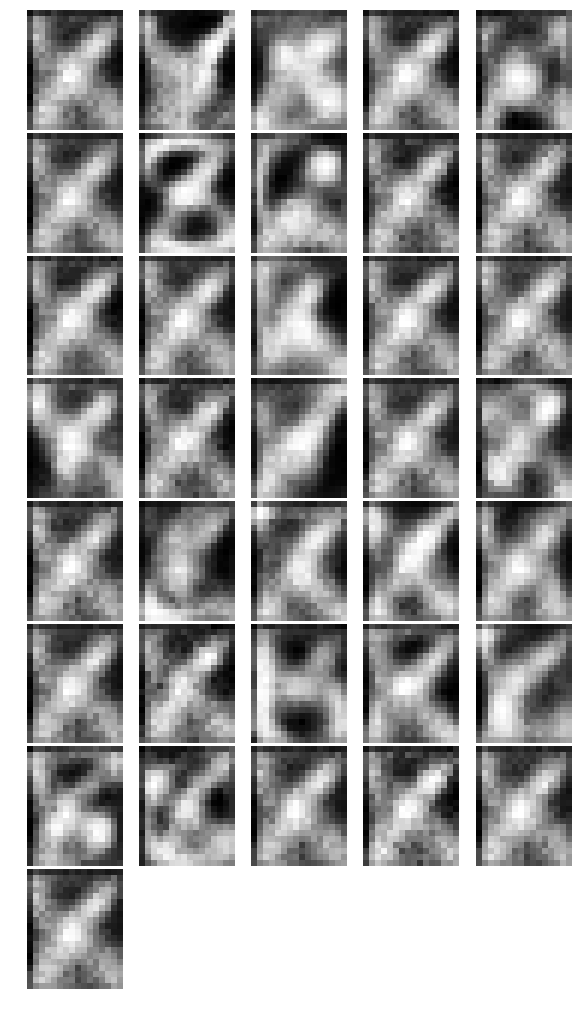

In [740]:
R.show_canonical()